# Predicting daily bikerider count from temperature and weekday

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

# import custom functions for data loading and plotting
import sys  
sys.path.insert(0, './../modules')
import m_data_loading as mdl
import m_plotting as mplot

## Import data

We import a dataset that contains the daily number of bike riders at a counting station in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.') in 2021 as well as the daily average temperature and a boolean whether a given day is a business day.

In [175]:
# counting station and time period
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2021, 12, 31)

# import data
combined_daily_dat = mdl.get_data_for_location(city_name, counter_site, channel_name, start_date, end_date)

In [176]:
# inspect
combined_daily_dat

,standort,counter_site,channel_name,longitude,latitude,date,temperature,is_busday,rider_count
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,1.4,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,0.8,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,-0.5,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,0.0,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,-0.7,True,1668
...,...,...,...,...,...,...,...,...,...
348,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-26,6.3,False,482
349,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,7.0,True,1395
350,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,10.0,True,1357
351,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,9.7,True,1299


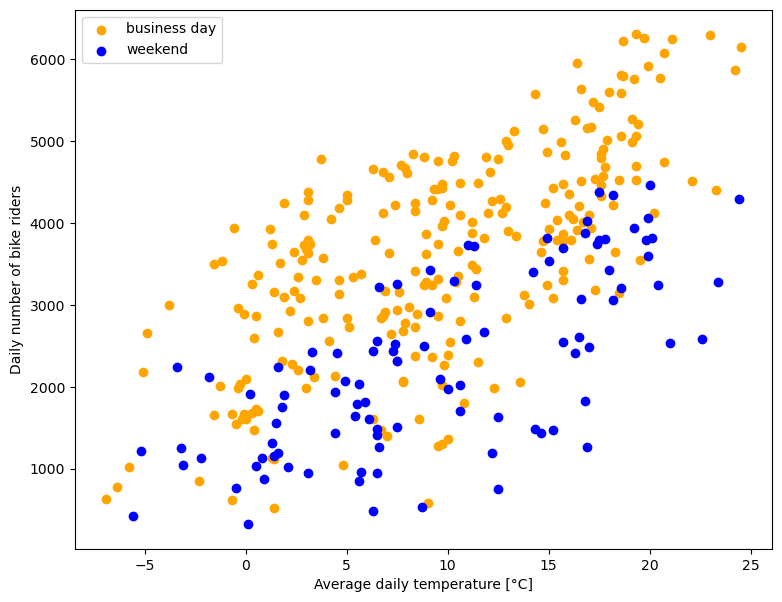

In [179]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.figure(figsize=(9,7))
plt.title(city_name + '\ncounter site: ' + counter_site + '\nchannel name: ' + channel_name);
mplot.plot_data()

## Statistical Analysis

Independent variables:  
$x_1$: daily average temperature [°C]  
$x_2$: indicator variable whether day is a business day $\{0,1\}$

Dependent variable:  
$y$: daily bike rider count


Multiple linear regression:  

$$\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2$$
$$y \sim \mathcal{N}(\mu, \sigma) $$


$\beta_0$: intercept on non-business days (i.e., bike rider count at $0°C$ on the weekend)  
$\beta_1$: slope on non-business days (weekends)  
$\beta_2$: additional intercept on business days  
$\beta_3$: interaction parameter (additional slope on business days)

So:
- on weeekends (i.e., $x_2 = 0$): $$\mu = \beta_0 + \beta_1 x_1$$
- on business days (i.e., $x_2 = 1$): $$\mu = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) x_1$$

### Bootstrapping

To avoid issues with distribution assumptions.

See also: https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9

In [269]:
# number of simulated experiments/datasets
B = 1000 # TODO increase

# number of samples per dataset
samples_per_dataset = combined_daily_dat.shape[0]

# initialize storage for results
results = np.zeros((B, 4))

# simulate B datasets and fit model to each of them 
for b in np.arange(B):
    
    # simulate dataset
    dat = combined_daily_dat.sample(n=samples_per_dataset, replace=True, axis=0)
    
    # fit model
    bootstrap_fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=dat).fit()
    
    # extract parameters and store them
    results[b, 0] = bootstrap_fit_daily_counts_ols.params['Intercept']
    results[b, 1] = bootstrap_fit_daily_counts_ols.params['temperature']
    results[b, 2] = bootstrap_fit_daily_counts_ols.params['is_busday[T.True]']
    results[b, 3] = bootstrap_fit_daily_counts_ols.params['temperature:is_busday[T.True]']

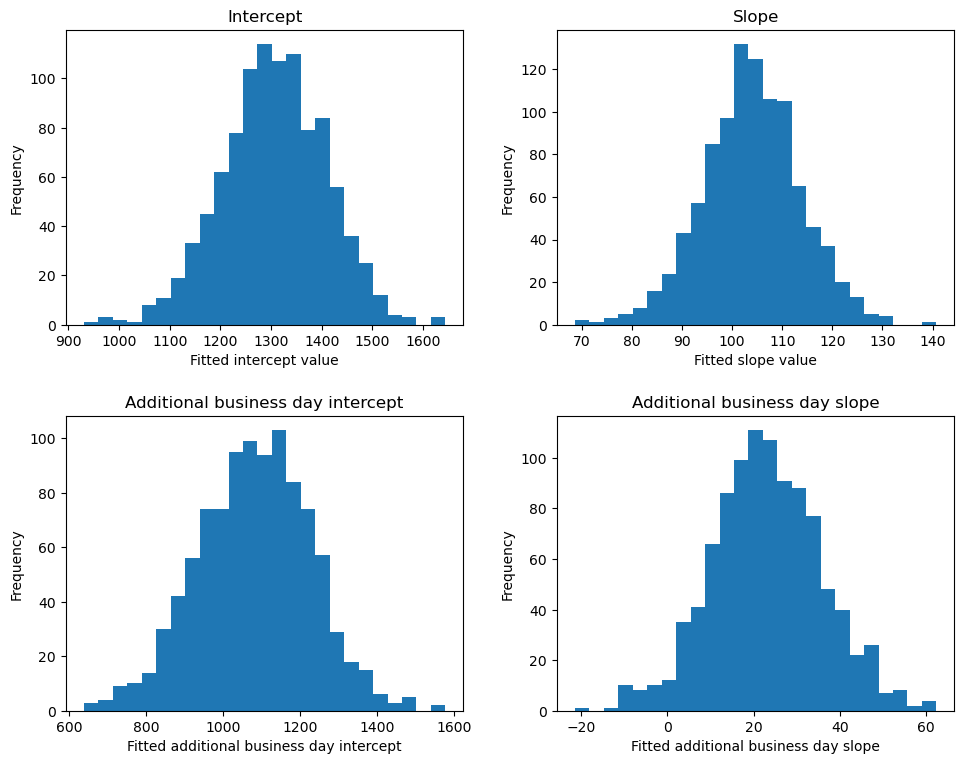

In [270]:
# plot bootstrapped results # TODO Wie nennt man das?

f = plt.figure(figsize=(10,8))

nbins=25

# intercept
ax = f.add_subplot(221)
ax.hist(results[:, 0], bins=nbins)
plt.xlabel('Fitted intercept value')
plt.ylabel('Frequency')
plt.title('Intercept');

# slope
ax = f.add_subplot(222)
ax.hist(results[:, 1], bins=nbins)
plt.xlabel('Fitted slope value')
plt.ylabel('Frequency')
plt.title('Slope');

# additional business day intercept
ax = f.add_subplot(223)
ax.hist(results[:, 2], bins=nbins)
plt.xlabel('Fitted additional business day intercept')
plt.ylabel('Frequency')
plt.title('Additional business day intercept');

# additional business day slope
ax = f.add_subplot(224)
ax.hist(results[:, 3], bins=nbins)
plt.xlabel('Fitted additional business day slope')
plt.ylabel('Frequency')
plt.title('Additional business day slope')

f.tight_layout(pad=2);

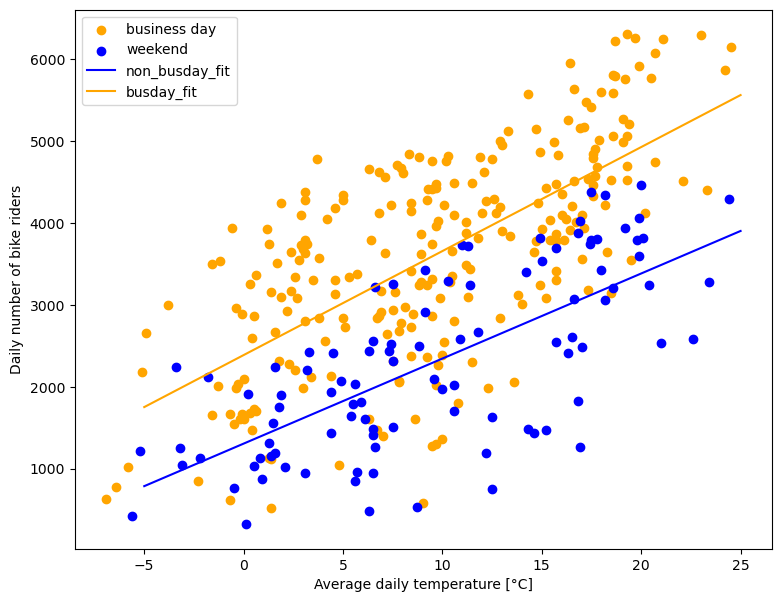

In [271]:
plt.figure(figsize=(9,7))
mplot.plot_data_and_linear_fit(
    results[:, 0].mean(),
    results[:, 1].mean(),
    results[:, 2].mean(),
    results[:, 3].mean()
)

# TODO Stimmt das, dass die means unsere estimates sind?
# TODO Oder vergleicht man ersten Fit an Daten mit Bootstrap-Verteilung?

---
TODO  
Notes:

Possible shortcomings of our analyis method / model:  

- linear model: maybe yields predictions < 0 (--> we assume that this is not an issue for our "region of interest" (i.e., from -5°C to 25°C))
- Normal distribution? --> maybe yields predictions that are not integers.
- Poisson for count data would be good. But: Assumption is violated: Mean $\neq$ Variance

To think about:  
Sind unsere Datenpunkte unabhängig voneinander? Wenn ich Fahrrad schonmal in Keller gebracht habe (für Winter), hole ich es vielleicht auch nicht mehr raus, auch wenn es nochmal wärmer werden sollte...